In [1]:
!pip -q install torchcodec hear21passt

In [2]:
import torch, torchaudio, pandas as pd, numpy as np
from pathlib import Path

print("torch:", torch.__version__)
print("torchaudio:", torchaudio.__version__)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("gpu:", torch.cuda.get_device_name(0))

# Speed knobs (safe on A100)
torch.backends.cudnn.benchmark = True
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass


torch: 2.9.0+cu126
torchaudio: 2.9.0+cu126
cuda available: True
gpu: NVIDIA A100-SXM4-80GB


/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!mkdir -p /content/openmic-2018-2
!mkdir -p /content/sentetik-dataset

# Copy OpenMIC audio + metadata (metadata optional)
!cp -r "/content/drive/MyDrive/openmic-2018-2/audio" "/content/openmic-2018-2/"
!cp "/content/drive/MyDrive/openmic-2018-2/openmic-2018-aggregated-labels.csv" "/content/openmic-2018-2/" || true
!cp "/content/drive/MyDrive/openmic-2018-2/openmic-2018-metadata.csv" "/content/openmic-2018-2/" || true

# Copy Synthetic audio + labels
!cp -r "/content/drive/MyDrive/deep_learning/sentetik-dataset/audio" "/content/sentetik-dataset/"
!cp "/content/drive/MyDrive/deep_learning/sentetik-dataset/labels.csv" "/content/sentetik-dataset/"

!du -sh /content/openmic-2018-2/audio || true
!du -sh /content/sentetik-dataset/audio || true


2.5G	/content/openmic-2018-2/audio
679M	/content/sentetik-dataset/audio


# 3 — Load combined CSV and patch paths to local

In [4]:
CSV_PATH = Path("/content/drive/MyDrive/deep_learning/combined_openmic_and_synth.csv")
assert CSV_PATH.exists(), f"Missing: {CSV_PATH}"

df = pd.read_csv(CSV_PATH, low_memory=False)

df["path"] = (
    df["path"]
    .str.replace("/content/drive/MyDrive/openmic-2018-2", "/content/openmic-2018-2", regex=False)
    .str.replace("/content/drive/MyDrive/deep_learning/sentetik-dataset", "/content/sentetik-dataset", regex=False)
)

# Quick sanity
sample = df.sample(500, random_state=0)
missing = sum(not Path(p).exists() for p in sample["path"])
print("Missing paths in sample(500):", missing)
print(df["source"].value_counts())


Missing paths in sample(500): 0
source
openmic      20000
synthetic     2200
Name: count, dtype: int64


In [5]:
TAGS = [
    "accordion","banjo","bass","cello","clarinet","cymbals","drums","flute","guitar","mallet_percussion",
    "mandolin","organ","piano","saxophone","synthesizer","trombone","trumpet","ukulele","violin","voice"
]
Y_COLS = [f"y_{t}" for t in TAGS]
M_COLS = [f"m_{t}" for t in TAGS]

missing_y = [c for c in Y_COLS if c not in df.columns]
missing_m = [c for c in M_COLS if c not in df.columns]
print("Missing y:", missing_y)
print("Missing m:", missing_m)
assert not missing_y and not missing_m, "Your combined CSV is missing required columns."


Missing y: []
Missing m: []


In [6]:
SPLIT_FILE = Path("/content/drive/MyDrive/deep_learning/splits_openmic_synth_v1.npz")

def make_split_indices(n, seed=42, train=0.8, valid=0.1, test=0.1):
    assert abs(train+valid+test-1.0) < 1e-9
    rng = np.random.default_rng(seed)
    idx = np.arange(n)
    rng.shuffle(idx)
    n_train = int(train*n)
    n_valid = int(valid*n)
    train_idx = idx[:n_train]
    valid_idx = idx[n_train:n_train+n_valid]
    test_idx  = idx[n_train+n_valid:]
    return train_idx, valid_idx, test_idx

if SPLIT_FILE.exists():
    sp = np.load(SPLIT_FILE)
    train_idx, valid_idx, test_idx = sp["train_idx"], sp["valid_idx"], sp["test_idx"]
    print("Loaded split from:", SPLIT_FILE)
else:
    train_idx, valid_idx, test_idx = make_split_indices(len(df), seed=42)
    np.savez(SPLIT_FILE, train_idx=train_idx, valid_idx=valid_idx, test_idx=test_idx)
    print("Saved split to:", SPLIT_FILE)

print("sizes:", len(train_idx), len(valid_idx), len(test_idx))


Loaded split from: /content/drive/MyDrive/deep_learning/splits_openmic_synth_v1.npz
sizes: 17760 2220 2220


In [7]:
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader

TARGET_SR = 32000
CLIP_SECONDS = 10
TARGET_LEN = TARGET_SR * CLIP_SECONDS

class AudioMultiLabelDS(Dataset):
    def __init__(self, df, indices):
        self.df = df.iloc[indices].reset_index(drop=True)
        self.paths = self.df["path"].tolist()
        self.y = self.df[Y_COLS].to_numpy(dtype=np.float32)
        self.m = self.df[M_COLS].to_numpy(dtype=np.float32)
        self.src = self.df["source"].tolist()

    def __len__(self):
        return len(self.df)

    def _load_audio(self, path: str):
        wav, sr = torchaudio.load(path)  # [C,T]
        if wav.ndim == 2 and wav.size(0) > 1:
            wav = wav.mean(dim=0, keepdim=True)  # mono [1,T]
        if sr != TARGET_SR:
            wav = torchaudio.functional.resample(wav, sr, TARGET_SR)

        # crop/pad to 10s
        T = wav.size(1)
        if T < TARGET_LEN:
            pad = TARGET_LEN - T
            wav = torch.nn.functional.pad(wav, (0, pad))
        elif T > TARGET_LEN:
            wav = wav[:, :TARGET_LEN]

        return wav.squeeze(0)  # [T]

    def __getitem__(self, idx):
        path = self.paths[idx]
        wav = self._load_audio(path)
        y = torch.from_numpy(self.y[idx])
        m = torch.from_numpy(self.m[idx])
        return wav, y, m, self.src[idx]

def collate(batch):
    wav, y, m, src = zip(*batch)
    return torch.stack(wav, 0), torch.stack(y, 0), torch.stack(m, 0), list(src)

BATCH_SIZE = 32  # safe starting point on A100; increase if GPU has headroom
NUM_WORKERS = 4

train_ds = AudioMultiLabelDS(df, train_idx)
valid_ds = AudioMultiLabelDS(df, valid_idx)
test_ds  = AudioMultiLabelDS(df, test_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS,
                          pin_memory=True, drop_last=True, collate_fn=collate)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS,
                          pin_memory=True, drop_last=False, collate_fn=collate)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS,
                          pin_memory=True, drop_last=False, collate_fn=collate)

print("train/valid/test:", len(train_ds), len(valid_ds), len(test_ds))


train/valid/test: 17760 2220 2220


#7 — Build pretrained PaSST model (replace head to 20 classes)

In [8]:
from hear21passt.base import get_basic_model, get_model_passt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Wrapper includes mel frontend + transformer
model = get_basic_model(mode="logits")

# Replace transformer with a 20-class head (pretrained backbone + new classifier head)
model.net = get_model_passt(arch="passt_s_swa_p16_128_ap476", n_classes=len(TAGS))

model = model.to(DEVICE)
print(model)




 Loading PASST TRAINED ON AUDISET 


PaSST(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), ep

# 8 — Loss (masked BCE) + metrics (macro-F1 at thresholds)

In [9]:
import time

bce = torch.nn.BCEWithLogitsLoss(reduction="none")

@torch.no_grad()
def macro_f1_from_logits(logits, y_true, mask, thr=0.5, eps=1e-9):
    # logits,y_true,mask: [N,C]
    probs = torch.sigmoid(logits)
    pred = (probs >= thr).float()

    # Apply mask: only evaluate where mask==1
    y_true = y_true * mask
    pred = pred * mask

    tp = (pred * y_true).sum(dim=0)
    fp = (pred * (1 - y_true)).sum(dim=0)
    fn = ((1 - pred) * y_true).sum(dim=0)

    precision = tp / (tp + fp + eps)
    recall    = tp / (tp + fn + eps)
    f1        = 2 * precision * recall / (precision + recall + eps)

    # Avoid classes with zero valid labels in mask (rare here, but safe)
    valid = (mask.sum(dim=0) > 0).float()
    macro = (f1 * valid).sum() / (valid.sum() + eps)
    return macro.item()

def masked_bce_loss(logits, y, m):
    per = bce(logits, y)            # [B,C]
    per = per * m                   # mask out unknown/unsupervised
    denom = m.sum().clamp(min=1.0)
    return per.sum() / denom


# 9 — Smoke test (verify finiteness + shapes)

In [11]:
model.train()
wav, y, m, src = next(iter(train_loader))
wav = wav.to(DEVICE)        # [B, T] @ 32kHz
y   = y.to(DEVICE)
m   = m.to(DEVICE)

with torch.no_grad():
    logits = model(wav)
print("wav:", tuple(wav.shape), "logits:", tuple(logits.shape),
      "finite:", torch.isfinite(logits).all().item(),
      "logits min/max:", float(logits.min()), float(logits.max()))


wav: (32, 320000) logits: (32, 20) finite: True logits min/max: -1.4267606735229492 2.188875436782837


In [12]:
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler

EPOCHS = 20
LR = 1e-4
WD = 1e-2
PATIENCE = 6
PRINT_EVERY = 50

optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WD)
scaler = GradScaler(enabled=(DEVICE=="cuda"))

BEST_PATH = Path("/content/drive/MyDrive/model_weights/finetuning/passt_openmic_plus_synth_best.pth")
BEST_PATH.parent.mkdir(parents=True, exist_ok=True)

history = {"train_loss": [], "val_loss": [], "val_f1_02": [], "val_f1_05": []}

def run_eval(loader):
    model.eval()
    losses = []
    all_logits, all_y, all_m = [], [], []

    with torch.no_grad():
        for wav, y, m, _ in loader:
            wav = wav.to(DEVICE, non_blocking=True)
            y   = y.to(DEVICE, non_blocking=True)
            m   = m.to(DEVICE, non_blocking=True)
            logits = model(wav)
            loss = masked_bce_loss(logits, y, m)
            losses.append(loss.item())

            all_logits.append(logits.detach().cpu())
            all_y.append(y.detach().cpu())
            all_m.append(m.detach().cpu())

    all_logits = torch.cat(all_logits, 0)
    all_y = torch.cat(all_y, 0)
    all_m = torch.cat(all_m, 0)
    val_loss = float(np.mean(losses))
    f1_02 = macro_f1_from_logits(all_logits, all_y, all_m, thr=0.2)
    f1_05 = macro_f1_from_logits(all_logits, all_y, all_m, thr=0.5)
    return val_loss, f1_02, f1_05

best_val = float("inf")
bad = 0

for epoch in range(1, EPOCHS+1):
    model.train()
    t0 = time.time()
    step_times = []
    losses = []

    n_steps = len(train_loader)
    for step, (wav, y, m, _) in enumerate(train_loader, start=1):
        ts = time.time()

        wav = wav.to(DEVICE, non_blocking=True)
        y   = y.to(DEVICE, non_blocking=True)
        m   = m.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=(DEVICE=="cuda")):
            logits = model(wav)
            loss = masked_bce_loss(logits, y, m)

        if not torch.isfinite(loss):
            print(f"[STOP] Non-finite loss at epoch {epoch} step {step}: {loss.item()}")
            raise RuntimeError("Loss became NaN/Inf. Reduce LR or disable AMP.")

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        losses.append(loss.item())
        step_times.append(time.time() - ts)

        if step % PRINT_EVERY == 0:
            sec = float(np.mean(step_times[-PRINT_EVERY:]))
            eta = (n_steps - step) * sec / 60.0
            print(f"epoch {epoch} step {step}/{n_steps} loss {np.mean(losses[-PRINT_EVERY:]):.4f} sec/step {sec:.3f} ETA {eta:.1f}m")

    train_loss = float(np.mean(losses))
    val_loss, f1_02, f1_05 = run_eval(valid_loader)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_f1_02"].append(f1_02)
    history["val_f1_05"].append(f1_05)

    print(f"epoch {epoch} DONE | {(time.time()-t0)/60:.1f}m | VAL loss {val_loss:.4f} | VAL macro-F1@0.2 {f1_02:.4f} | @0.5 {f1_05:.4f}")

    # checkpoint by val loss (consistent with your MS-CRNN run)
    if val_loss < best_val - 1e-6:
        best_val = val_loss
        bad = 0
        torch.save(model.state_dict(), BEST_PATH)
        print("Saved best:", str(BEST_PATH), "val_loss:", best_val)
    else:
        bad += 1
        if bad >= PATIENCE:
            print(f"Early stopping. Best val_loss: {best_val:.4f}")
            break


/tmp/ipython-input-2493029817.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(DEVICE=="cuda"))
/tmp/ipython-input-2493029817.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE=="cuda")):


epoch 1 step 50/555 loss 0.1930 sec/step 0.687 ETA 5.8m
epoch 1 step 100/555 loss 0.1285 sec/step 0.665 ETA 5.0m
epoch 1 step 150/555 loss 0.1121 sec/step 0.665 ETA 4.5m
epoch 1 step 200/555 loss 0.1082 sec/step 0.665 ETA 3.9m
epoch 1 step 250/555 loss 0.1051 sec/step 0.665 ETA 3.4m
epoch 1 step 300/555 loss 0.1074 sec/step 0.665 ETA 2.8m
epoch 1 step 350/555 loss 0.1049 sec/step 0.665 ETA 2.3m
epoch 1 step 400/555 loss 0.1008 sec/step 0.665 ETA 1.7m
epoch 1 step 450/555 loss 0.0982 sec/step 0.665 ETA 1.2m
epoch 1 step 500/555 loss 0.0986 sec/step 0.665 ETA 0.6m
epoch 1 step 550/555 loss 0.0947 sec/step 0.665 ETA 0.1m
epoch 1 DONE | 6.5m | VAL loss 0.0883 | VAL macro-F1@0.2 0.6559 | @0.5 0.6202
Saved best: /content/drive/MyDrive/model_weights/finetuning/passt_openmic_plus_synth_best.pth val_loss: 0.08825467191636563
epoch 2 step 50/555 loss 0.0891 sec/step 0.666 ETA 5.6m
epoch 2 step 100/555 loss 0.0856 sec/step 0.665 ETA 5.0m
epoch 2 step 150/555 loss 0.0874 sec/step 0.665 ETA 4.5m
ep

# 11 — Test evaluation

In [13]:
# Load best
model.load_state_dict(torch.load(BEST_PATH, map_location=DEVICE))

test_loss, test_f1_02, test_f1_05 = run_eval(test_loader)
print("TEST loss:", test_loss)
print("TEST macro-F1@0.2:", test_f1_02)
print("TEST macro-F1@0.5:", test_f1_05)


TEST loss: 0.09162010630326611
TEST macro-F1@0.2: 0.6706840991973877
TEST macro-F1@0.5: 0.6163100600242615


# 12 — Per-class metrics CSV (precision/recall/F1)

In [14]:
import pandas as pd

@torch.no_grad()
def per_class_metrics(loader, thr=0.5, eps=1e-9):
    model.eval()
    all_logits, all_y, all_m = [], [], []
    for wav, y, m, _ in loader:
        wav = wav.to(DEVICE, non_blocking=True)
        logits = model(wav).detach().cpu()
        all_logits.append(logits)
        all_y.append(y)
        all_m.append(m)

    logits = torch.cat(all_logits, 0)
    y = torch.cat(all_y, 0).float()
    m = torch.cat(all_m, 0).float()

    probs = torch.sigmoid(logits)
    pred = (probs >= thr).float()

    # apply mask
    y = y * m
    pred = pred * m

    tp = (pred * y).sum(dim=0)
    fp = (pred * (1 - y)).sum(dim=0)
    fn = ((1 - pred) * y).sum(dim=0)

    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)

    pos_n = y.sum(dim=0)
    valid_n = m.sum(dim=0)

    rows = []
    for i, tag in enumerate(TAGS):
        rows.append({
            "tag": tag,
            "thr": thr,
            "valid_n": int(valid_n[i].item()),
            "pos_n": int(pos_n[i].item()),
            "precision": float(precision[i].item()),
            "recall": float(recall[i].item()),
            "f1": float(f1[i].item()),
            "tp": int(tp[i].item()),
            "fp": int(fp[i].item()),
            "fn": int(fn[i].item())
        })
    return pd.DataFrame(rows)

df_05 = per_class_metrics(test_loader, thr=0.5)
df_02 = per_class_metrics(test_loader, thr=0.2)

print("Top-10 classes by F1@0.5:")
display(df_05.sort_values("f1", ascending=False).head(10))

print("Bottom-10 classes by F1@0.5:")
display(df_05.sort_values("f1", ascending=True).head(10))

OUT = Path("/content/drive/MyDrive/deep_learning/passt_test_per_class_metrics.csv")
df_05.to_csv(OUT, index=False)
print("Saved:", OUT)


Top-10 classes by F1@0.5:


,tag,thr,valid_n,pos_n,precision,recall,f1,tp,fp,fn
12,piano,0.5,2220,241,0.785992,0.838174,0.811245,202,55,39
14,synthesizer,0.5,2220,231,0.772152,0.792208,0.782051,183,54,48
18,violin,0.5,2003,128,0.836364,0.718750,0.773109,92,18,36
11,organ,0.5,2220,189,0.772487,0.772487,0.772487,146,43,43
6,drums,0.5,2003,135,0.811966,0.703704,0.753968,95,22,40
9,mallet_percussion,0.5,2220,191,0.693694,0.806283,0.745763,154,68,37
7,flute,0.5,2220,201,0.715640,0.751244,0.733010,151,60,50
19,voice,0.5,2220,215,0.812500,0.665116,0.731458,143,33,72
8,guitar,0.5,2220,235,0.684015,0.782979,0.730159,184,85,51
5,cymbals,0.5,2003,131,0.648485,0.816794,0.722973,107,58,24


Bottom-10 classes by F1@0.5:


,tag,thr,valid_n,pos_n,precision,recall,f1,tp,fp,fn
4,clarinet,0.5,2003,47,1.000000,0.021277,0.041667,1,0,46
15,trombone,0.5,2003,85,0.866667,0.152941,0.260000,13,2,72
1,banjo,0.5,2003,70,0.941176,0.228571,0.367816,16,1,54
3,cello,0.5,2003,85,0.878788,0.341176,0.491525,29,4,56
16,trumpet,0.5,2003,96,0.787234,0.385417,0.517483,37,10,59
17,ukulele,0.5,2003,60,0.438095,0.766667,0.557576,46,59,14
10,mandolin,0.5,2003,86,0.709677,0.511628,0.594595,44,18,42
13,saxophone,0.5,2003,103,0.659341,0.582524,0.618557,60,31,43
0,accordion,0.5,2003,48,0.717949,0.583333,0.643678,28,11,20
2,bass,0.5,2220,182,0.643564,0.714286,0.677083,130,72,52


Saved: /content/drive/MyDrive/deep_learning/passt_test_per_class_metrics.csv


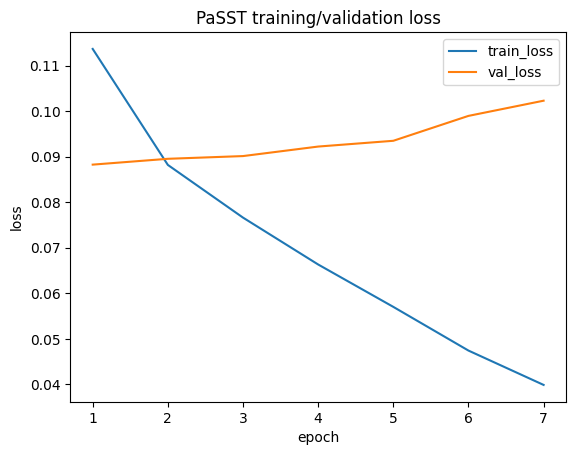

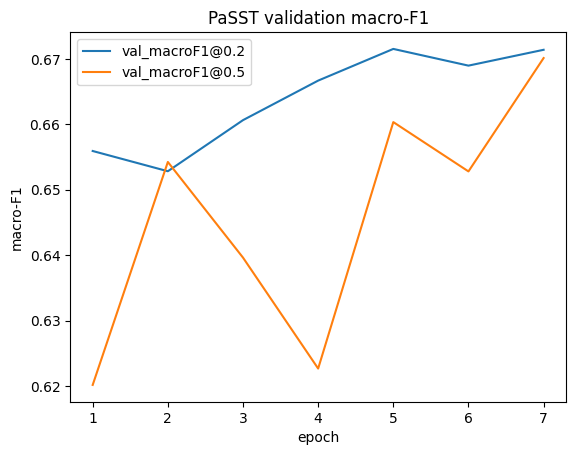

In [15]:
import matplotlib.pyplot as plt

epochs_r = range(1, len(history["train_loss"]) + 1)

plt.figure()
plt.plot(list(epochs_r), history["train_loss"], label="train_loss")
plt.plot(list(epochs_r), history["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title("PaSST training/validation loss")
plt.show()

plt.figure()
plt.plot(list(epochs_r), history["val_f1_02"], label="val_macroF1@0.2")
plt.plot(list(epochs_r), history["val_f1_05"], label="val_macroF1@0.5")
plt.xlabel("epoch")
plt.ylabel("macro-F1")
plt.legend()
plt.title("PaSST validation macro-F1")
plt.show()
